In [83]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
#from statsmodels.graphics.tsaplots import plot_acf
#from statsmodels.graphics.tsaplots import plot_pacf
#import plotly.graph_objects as go
#import plotly.io as pio
#import plotly.offline as poff
#pio.templates.default = "seaborn"t
#poff.init_notebook_mode(connected=True)
#plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
#import skforecast
from tqdm.notebook import tqdm

import utils
from feature_engineering import codify_date, codify_date_2, remove_outliers, get_X_y, covid_19, covid_19_2
from feature_engineering import add_weather, add_lag_and_rolling_features
from utils import handle_missing_values
from pathlib import Path



In [203]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, OneStepAheadFold
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.model_selection import bayesian_search_forecaster_multiseries
from skforecast.feature_selection import select_features_multiseries
from skforecast.preprocessing import RollingFeatures
from skforecast.plot import set_dark_theme
from skforecast.exceptions import OneStepAheadValidationWarning
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


In [206]:
data = pd.read_parquet(Path("data") / "train.parquet")
data = codify_date_2(data)
data = remove_outliers(data)
data = covid_19_2(data)
#data = add_weather(data)
#data = handle_missing_values(data, "linear")
data = data.drop(columns=["counter_id", "site_id", "site_name", 
                                "counter_installation_date", 
                              "coordinates", "counter_technical_id",
                              "latitude", "longitude", "date", "bike_count"])
data.head()

/Users/joaosilva/Current/École Polytechnique/Python for Data Science/Project/bike_counters/feature_engineering.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["counter_name", "date_truncated"])
/Users/joaosilva/Current/École Polytechnique/Python for Data Science/Project/bike_counters/feature_engineering.py:72: DtypeWarning: Columns (2,3,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  covid_19_index = pd.read_csv(Path("data") / "Covid_19_Index.csv")


,StringencyIndex_Average,counter_name,log_bike_count,datetime,year,month,day,day_of_week,hour,is_weekend,IsHoliday
0,46.76,28 boulevard Diderot E-O,0.000000,2020-09-01 02:00:00,2020,9,1,1,2,False,False
1,46.76,28 boulevard Diderot E-O,0.693147,2020-09-01 03:00:00,2020,9,1,1,3,False,False
2,46.76,28 boulevard Diderot E-O,0.000000,2020-09-01 04:00:00,2020,9,1,1,4,False,False
3,46.76,28 boulevard Diderot E-O,1.609438,2020-09-01 15:00:00,2020,9,1,1,15,False,False
4,46.76,28 boulevard Diderot E-O,2.302585,2020-09-01 18:00:00,2020,9,1,1,18,False,False


In [314]:
series = data[["counter_name", "datetime", "log_bike_count"]]
exog = data[["counter_name", "datetime", "StringencyIndex_Average", "year", "month", "hour", "day_of_week", "IsHoliday"]]

In [315]:
categorical_columns = ["year", "month", "day", "hour", "day_of_week", "IsHoliday"]
def cyclic_transform(df, col, period):
    df[f"{col}_sin"] = np.sin(2 * np.pi * df[col] / period)
    df[f"{col}_cos"] = np.cos(2 * np.pi * df[col] / period)
    df = df.drop(columns=col)
    return df

# Apply sine and cosine transformations
exog["year"] = exog["year"].astype(float)
exog["IsHoliday"] = exog["IsHoliday"].astype(float)
exog = cyclic_transform(exog, "month", 12)
exog = cyclic_transform(exog, "hour", 24)
exog = cyclic_transform(exog, "day_of_week", 7)

/var/folders/b3/l_t9dzy13rz2smp7vyx9352h0000gn/T/ipykernel_61121/44431586.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["year"] = exog["year"].astype(float)
/var/folders/b3/l_t9dzy13rz2smp7vyx9352h0000gn/T/ipykernel_61121/44431586.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["IsHoliday"] = exog["IsHoliday"].astype(float)
/var/folders/b3/l_t9dzy13rz2smp7vyx9352h0000gn/T/ipykernel_61121/44431586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [316]:
exog.head()

,counter_name,datetime,StringencyIndex_Average,year,IsHoliday,month_sin,month_cos,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
0,28 boulevard Diderot E-O,2020-09-01 02:00:00,46.76,2020.0,0.0,-1.0,-1.836970e-16,0.500000,8.660254e-01,0.781831,0.62349
1,28 boulevard Diderot E-O,2020-09-01 03:00:00,46.76,2020.0,0.0,-1.0,-1.836970e-16,0.707107,7.071068e-01,0.781831,0.62349
2,28 boulevard Diderot E-O,2020-09-01 04:00:00,46.76,2020.0,0.0,-1.0,-1.836970e-16,0.866025,5.000000e-01,0.781831,0.62349
3,28 boulevard Diderot E-O,2020-09-01 15:00:00,46.76,2020.0,0.0,-1.0,-1.836970e-16,-0.707107,-7.071068e-01,0.781831,0.62349
4,28 boulevard Diderot E-O,2020-09-01 18:00:00,46.76,2020.0,0.0,-1.0,-1.836970e-16,-1.000000,-1.836970e-16,0.781831,0.62349


In [317]:
series_dict = series_long_to_dict(
    data      = series,
    series_id = 'counter_name',
    index     = 'datetime',
    values    = 'log_bike_count',
    freq      = 'H'
)

exog_dict = exog_long_to_dict(
    data      = exog,
    series_id = 'counter_name',
    index     = 'datetime',
    freq      = 'H'
)

/opt/homebrew/Caskroom/miniforge/base/envs/test_bike/lib/python3.12/site-packages/skforecast/preprocessing/preprocessing.py:418: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  original_sizes = data.groupby(series_id).size()
/opt/homebrew/Caskroom/miniforge/base/envs/test_bike/lib/python3.12/site-packages/skforecast/preprocessing/preprocessing.py:420: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for k, v in data.groupby(series_id):
/opt/homebrew/Caskroom/miniforge/base/envs/test_bike/lib/python3.12/site-packages/skforecast/preprocessing/preprocessing.py:421: FutureWarning: 'H' is deprecated and will be removed

In [318]:
# Partition data in train and test
# ==============================================================================
end_train = '2021-08-09 23:00:00'
series_dict_train = {k: v.loc[: end_train,] for k, v in series_dict.items()}
exog_dict_train   = {k: v.loc[: end_train,] for k, v in exog_dict.items()}
series_dict_test  = {k: v.loc[end_train:,] for k, v in series_dict.items()}
exog_dict_test    = {k: v.loc[end_train:,] for k, v in exog_dict.items()}

In [210]:
# Description of each series
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(
            f"\tTrain: len={len(series_dict_train[k])}, {series_dict_train[k].index[0]}"
            f" --- {series_dict_train[k].index[-1]} "
            f" (missing={series_dict_train[k].isnull().sum()})"
        )
    except:
        print(f"\tTrain: len=0")
    try:
        print(
            f"\tTest : len={len(series_dict_test[k])}, {series_dict_test[k].index[0]}"
            f" --- {series_dict_test[k].index[-1]} "
            f" (missing={series_dict_test[k].isnull().sum()})"
        )
    except:
        print(f"\tTest : len=0")


152 boulevard du Montparnasse E-O:
	Train: len=8231, 2020-09-01 01:00:00 --- 2021-08-09 23:00:00  (missing=703)
	Test : len=745, 2021-08-09 23:00:00 --- 2021-09-09 23:00:00  (missing=0)
152 boulevard du Montparnasse O-E:
	Train: len=8231, 2020-09-01 01:00:00 --- 2021-08-09 23:00:00  (missing=703)
	Test : len=745, 2021-08-09 23:00:00 --- 2021-09-09 23:00:00  (missing=0)
18 quai de l'Hôtel de Ville NO-SE:
	Train: len=8231, 2020-09-01 01:00:00 --- 2021-08-09 23:00:00  (missing=1)
	Test : len=745, 2021-08-09 23:00:00 --- 2021-09-09 23:00:00  (missing=0)
18 quai de l'Hôtel de Ville SE-NO:
	Train: len=8231, 2020-09-01 01:00:00 --- 2021-08-09 23:00:00  (missing=1)
	Test : len=745, 2021-08-09 23:00:00 --- 2021-09-09 23:00:00  (missing=0)
20 Avenue de Clichy NO-SE:
	Train: len=8231, 2020-09-01 01:00:00 --- 2021-08-09 23:00:00  (missing=1921)
	Test : len=745, 2021-08-09 23:00:00 --- 2021-09-09 23:00:00  (missing=0)
20 Avenue de Clichy SE-NO:
	Train: len=8231, 2020-09-01 01:00:00 --- 2021-08-09 2

In [211]:
# Exogenous variables for each series
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(f"\t{exog_dict[k].columns.to_list()}")
    except:
        print(f"\tNo exogenous variables")

152 boulevard du Montparnasse E-O:
	['StringencyIndex_Average', 'year', 'month', 'day', 'hour']
152 boulevard du Montparnasse O-E:
	['StringencyIndex_Average', 'year', 'month', 'day', 'hour']
18 quai de l'Hôtel de Ville NO-SE:
	['StringencyIndex_Average', 'year', 'month', 'day', 'hour']
18 quai de l'Hôtel de Ville SE-NO:
	['StringencyIndex_Average', 'year', 'month', 'day', 'hour']
20 Avenue de Clichy NO-SE:
	['StringencyIndex_Average', 'year', 'month', 'day', 'hour']
20 Avenue de Clichy SE-NO:
	['StringencyIndex_Average', 'year', 'month', 'day', 'hour']
254 rue de Vaugirard NE-SO:
	['StringencyIndex_Average', 'year', 'month', 'day', 'hour']
254 rue de Vaugirard SO-NE:
	['StringencyIndex_Average', 'year', 'month', 'day', 'hour']
27 quai de la Tournelle NO-SE:
	['StringencyIndex_Average', 'year', 'month', 'day', 'hour']
27 quai de la Tournelle SE-NO:
	['StringencyIndex_Average', 'year', 'month', 'day', 'hour']
28 boulevard Diderot E-O:
	['StringencyIndex_Average', 'year', 'month', 'day',

In [212]:
from sklearn.preprocessing import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [ ]:
# Fit forecaster
# ==============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

window_features = RollingFeatures(stats=['mean', 'mean'], window_sizes=[24, 168])
forecaster = ForecasterRecursiveMultiSeries(
                regressor          = HistGradientBoostingRegressor(random_state=123),
                lags               = [1, 24, 168],
                window_features    = window_features,
                encoding           = "ordinal",
                dropna_from_series = False
            )

forecaster.fit(series=series_dict_train, exog=exog_dict_train, suppress_warnings=True)
forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: HistGradientBoostingRegressor 
Lags: [  1  24 168 720] 
Window features: ['roll_mean_24', 'roll_mean_168'] 
Window size: 720 
Series encoding: ordinal 
Series names (levels): 
    152 boulevard du Montparnasse E-O, 152 boulevard du Montparnasse O-E, 18 quai de
    l'Hôtel de Ville NO-SE, 18 quai de l'Hôtel de Ville SE-NO, 20 Avenue de
    Clichy NO-SE, 20 Avenue de Clichy SE-NO, 254 rue de Vaugirard NE-SO, 254 rue
    de Vaugirard SO-NE, 27 quai de la Tournelle NO-SE, 27 quai de la Tournelle
    SE-NO, 28 boulevard Diderot E-O, 28 boulevard Diderot O-E, 36 quai de
    Grenelle NE-SO, 36 quai de Grenelle SO-NE, 38 rue Turbigo NE-SO, 38 rue
    Turbigo SO-NE, 39 quai François Mauriac NO-SE, 39 quai François Mauriac SE-
    NO, 6 rue Julia Bartet NE-SO, 6 rue Julia Bartet SO-NE, 67 boulevard
    Voltaire SE-NO, 90 Rue De Sèvres NE-SO, 90 Rue De Sèvres SO-NE, Face 104 rue
    d'Aubervilliers N-S, Face 104 rue d'Aubervilliers S-N, ..., Face au 48 quai
    de la marne NE-SO, Face au 48 quai de la marne SO-NE, Face au 70 quai de
    Bercy N-S, Face au 70 quai de Bercy S-N, Face au 8 avenue de la porte de
    Charenton NO-SE, Face au 8 avenue de la porte de Charenton SE-NO, Pont
    Charles De Gaulle NE-SO, Pont Charles De Gaulle SO-NE, Pont de Bercy NE-SO,
    Pont de Bercy SO-NE, Pont de la Concorde S-N, Pont des Invalides N-S, Pont
    des Invalides S-N, Quai d'Orsay E-O, Quai d'Orsay O-E, Totem 64 Rue de
    Rivoli E-O, Totem 64 Rue de Rivoli O-E, Totem 73 boulevard de Sébastopol
    N-S, Totem 73 boulevard de Sébastopol S-N, Totem 85 quai d'Austerlitz NO-SE,
    Totem 85 quai d'Austerlitz SE-NO, Totem Cours la Reine E-O, Totem Cours la
    Reine O-E, Voie Georges Pompidou NE-SO, Voie Georges Pompidou SO-NE 
Exogenous included: True 
Exogenous names: 
    StringencyIndex_Average, year, IsHoliday, month_sin, month_cos, hour_sin,
    hour_cos, day_of_week_sin, day_of_week_cos 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    '152 boulevard du Montparnasse E-O': ['2020-09-01 01:00:00', '2021-08-09
    23:00:00'], '152 boulevard du Montparnasse O-E': ['2020-09-01 01:00:00',
    '2021-08-09 23:00:00'], '18 quai de l'Hôtel de Ville NO-SE': ['2020-09-01
    01:00:00', '2021-08-09 23:00:00'], '18 quai de l'Hôtel de Ville SE-NO':
    ['2020-09-01 01:00:00', '2021-08-09 23:00:00'], '20 Avenue de Clichy NO-SE':
    ['2020-09-01 01:00:00', '2021-08-09 23:00:00'], ..., 'Totem 85 quai
    d'Austerlitz SE-NO': ['2020-09-01 01:00:00', '2021-08-09 23:00:00'], 'Totem
    Cours la Reine E-O': ['2020-09-01 01:00:00', '2021-08-09 23:00:00'], 'Totem
    Cours la Reine O-E': ['2020-09-01 01:00:00', '2021-08-09 23:00:00'], 'Voie
    Georges Pompidou NE-SO': ['2020-09-01 01:00:00', '2021-08-09 23:00:00'],
    'Voie Georges Pompidou SO-NE': ['2020-09-01 01:00:00', '2021-08-09
    23:00:00'] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'categorical_features': 'warn', 'early_stopping': 'auto', 'interaction_cst':
    None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss':
    'squared_error', 'max_bins': 255, 'max_depth': None, 'max_features': 1.0,
    'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20,
    'monotonic_cst': None, 'n_iter_no_change': 10, 'quantile': None,
    'random_state': 123, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction':
    0.1, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-12-11 00:28:18 
Last fit date: 2024-12-11 00:28:22 
Skforecast version: 0.14.0 
Python version: 3.12.4 
Forecaster id: None

In [335]:
predictions = forecaster.predict(steps=1020, exog=exog_dict_test)

/opt/homebrew/Caskroom/miniforge/base/envs/test_bike/lib/python3.12/site-packages/skforecast/utils/utils.py:966: MissingValuesWarning: `exog` for series '152 boulevard du Montparnasse E-O' doesn't have as many values as steps predicted, 1020. Missing values are filled with NaN. Most of machine learning models do not allow missing values. Prediction method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/test_bike/lib/python3.12/site-packages/skforecast/utils/utils.py:1036: MissingValuesWarning: To make predictions `exog` for series '152 boulevard du Montparnasse E-O' must start one step ahead of `last_window`. Missing values are filled with NaN.
    `last_window` ends at : 2021-08-09 23:00:00.
    `exog` for series '152 boulevard du Montparnasse E-O' starts at : 2021-08-09 23:00:00.
     Expected index       : 2021-08-10 00:00:00. 
 You can suppress this warning us

In [336]:
predictions = predictions.reset_index(names='datetime').melt(id_vars=['datetime'], var_name='counter_name', value_name='log_bike_count')
predictions.head()

,datetime,counter_name,log_bike_count
0,2021-08-10 00:00:00,152 boulevard du Montparnasse E-O,1.098025
1,2021-08-10 01:00:00,152 boulevard du Montparnasse E-O,0.845284
2,2021-08-10 02:00:00,152 boulevard du Montparnasse E-O,0.897646
3,2021-08-10 03:00:00,152 boulevard du Montparnasse E-O,0.911088
4,2021-08-10 04:00:00,152 boulevard du Montparnasse E-O,2.093849


In [322]:
predictions.shape

(57120, 3)

In [337]:
series_test = series.query(f"datetime >= '{end_train}'")
series_test.head()

,counter_name,datetime,log_bike_count
7813,28 boulevard Diderot E-O,2021-08-10 05:00:00,0.693147
7816,28 boulevard Diderot E-O,2021-08-10 06:00:00,1.098612
7819,28 boulevard Diderot E-O,2021-08-10 07:00:00,0.693147
7822,28 boulevard Diderot E-O,2021-08-10 09:00:00,0.000000
7825,28 boulevard Diderot E-O,2021-08-10 10:00:00,0.693147


In [324]:
series_test.shape

(41720, 3)

In [338]:
merged_df = series_test.merge(predictions, on=['counter_name', 'datetime'], how='inner')

In [326]:
merged_df.shape

(41664, 4)

In [339]:
from sklearn.metrics import root_mean_squared_error


root_mean_squared_error(merged_df["log_bike_count_x"], merged_df["log_bike_count_y"])

np.float64(0.651313305487515)

In [163]:
merged_df.shape

(41720, 4)

In [134]:
# Backtesting
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 720,
        initial_train_size = len(series_dict_train["254 rue de Vaugirard NE-SO"]),
        refit              = False,
     )

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = series_dict,
    exog                  = exog_dict,
    cv                    = cv,
    metric                = "mean_absolute_error",
    add_aggregated_metric = False,
    n_jobs                = "auto",
    verbose               = True,
    show_progress         = True,
    suppress_warnings     = True
)

display(metrics_levels)
print("")
display(backtest_predictions)

Information of folds
--------------------
Number of observations used for initial training: 5833
Number of observations used for backtesting: 3142
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 720
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 262 observations.

Fold: 0
    Training:   2020-09-01 01:00:00 -- 2021-05-02 01:00:00  (n=5833)
    Validation: 2021-05-02 02:00:00 -- 2021-06-01 01:00:00  (n=720)
Fold: 1
    Training:   No training in this fold
    Validation: 2021-06-01 02:00:00 -- 2021-07-01 01:00:00  (n=720)
Fold: 2
    Training:   No training in this fold
    Validation: 2021-07-01 02:00:00 -- 2021-07-31 01:00:00  (n=720)
Fold: 3
    Training:   No training in this fold
    Validation: 2021-07-31 02:00:00 -- 2021-08-30 01:00:00  (n=720)
Fold: 4
    Training:   No training in this fold
    Validation: 2021-08-30 02:00:00 -- 2021-09-09 23:00:00  (n=262)



100%|██████████| 5/5 [00:00<00:00, 24.69it/s]


,levels,mean_absolute_error
0,152 boulevard du Montparnasse E-O,0.497200
1,152 boulevard du Montparnasse O-E,0.517546
2,18 quai de l'Hôtel de Ville NO-SE,0.553849
3,18 quai de l'Hôtel de Ville SE-NO,0.547779
4,20 Avenue de Clichy NO-SE,0.928812
5,20 Avenue de Clichy SE-NO,0.942773
6,254 rue de Vaugirard NE-SO,0.563593
7,254 rue de Vaugirard SO-NE,0.525831
8,27 quai de la Tournelle NO-SE,0.536712
9,27 quai de la Tournelle SE-NO,0.496732


,152 boulevard du Montparnasse E-O,152 boulevard du Montparnasse O-E,18 quai de l'Hôtel de Ville NO-SE,18 quai de l'Hôtel de Ville SE-NO,20 Avenue de Clichy NO-SE,20 Avenue de Clichy SE-NO,254 rue de Vaugirard NE-SO,254 rue de Vaugirard SO-NE,27 quai de la Tournelle NO-SE,27 quai de la Tournelle SE-NO,...,Totem 64 Rue de Rivoli E-O,Totem 64 Rue de Rivoli O-E,Totem 73 boulevard de Sébastopol N-S,Totem 73 boulevard de Sébastopol S-N,Totem 85 quai d'Austerlitz NO-SE,Totem 85 quai d'Austerlitz SE-NO,Totem Cours la Reine E-O,Totem Cours la Reine O-E,Voie Georges Pompidou NE-SO,Voie Georges Pompidou SO-NE
2021-05-02 02:00:00,0.948383,0.648086,0.821895,1.240113,0.116001,0.116001,1.436338,0.881225,1.599988,1.537467,...,1.535789,2.324152,2.866553,2.176038,0.819971,1.118677,0.927009,1.417101,0.510725,0.904420
2021-05-02 03:00:00,1.107040,1.076790,0.636733,0.893344,0.297915,0.297915,1.198766,1.613732,0.983623,1.877372,...,1.755506,2.143091,2.180781,2.063872,1.090583,0.877788,0.648598,1.028979,0.754091,0.817890
2021-05-02 04:00:00,1.174576,1.253730,0.886307,0.614277,0.297915,0.297915,0.970240,1.569001,1.557070,2.473305,...,2.337235,2.139504,2.715472,2.734452,2.048821,1.644589,1.412661,1.238716,0.510725,1.094176
2021-05-02 05:00:00,1.790712,1.769045,1.029180,1.297303,0.297915,0.297915,1.977695,2.265346,2.513167,2.869404,...,2.312772,2.793243,3.392932,3.050345,1.771626,2.582064,1.727958,2.631222,1.560424,2.383551
2021-05-02 06:00:00,2.653746,2.721531,1.781988,1.964900,0.297915,0.825776,2.995749,3.083367,3.195706,3.759472,...,3.488615,3.673989,3.997489,3.756346,3.034517,2.766738,2.979291,3.222318,2.611926,3.168642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-09 19:00:00,4.186170,3.754896,3.872671,3.802567,5.266583,4.842870,4.522713,4.399632,4.852757,4.950584,...,4.816545,5.883187,5.601131,5.971239,4.228147,4.748823,3.950293,4.880638,4.037935,4.123556
2021-09-09 20:00:00,4.159442,3.496797,3.426914,3.517444,5.005580,4.303341,4.341098,4.186608,4.696213,4.726309,...,4.703703,5.576630,5.304163,5.822206,3.849941,4.389854,3.860174,4.520951,3.713074,3.408961
2021-09-09 21:00:00,3.850429,3.049766,3.040972,3.233587,4.939650,3.999028,4.358669,3.820290,4.580554,4.528411,...,4.405312,5.374459,5.136582,5.685967,3.650888,4.300703,3.765828,4.155648,3.435492,2.946149
2021-09-09 22:00:00,3.137404,2.666380,2.617107,2.666181,4.698746,3.382434,3.701082,3.111677,4.217244,4.139689,...,3.837154,4.982408,4.517018,5.442551,3.125790,3.920926,3.083028,3.806290,2.996447,2.423581


IndexError: index 5 is out of bounds for axis 0 with size 5

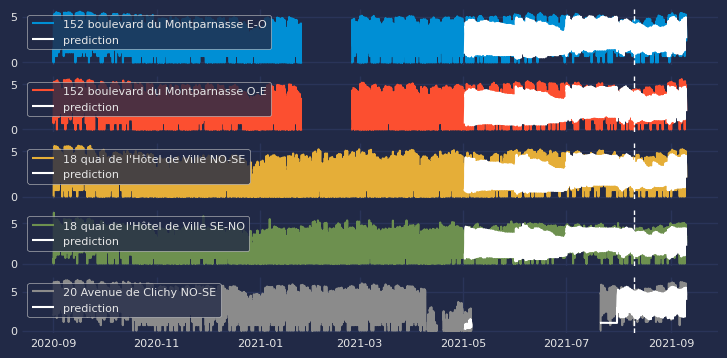

In [124]:
# Plot backtesting predictions
# ==============================================================================
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)
for i, s in enumerate(series_dict.keys()):
    axs[i].plot(series_dict[s], label=series_dict[s].name, color=colors[i])
    axs[i].axvline(pd.to_datetime(end_train), color='white', linestyle='--', linewidth=1)
    try:
        axs[i].plot(backtest_predictions[s], label='prediction', color="white")
    except:
        pass
    axs[i].legend(loc='upper left', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)

In [118]:
# Hyperparameter search for the multi-series model and backtesting for each item
# ======================================================================================
import warnings


def search_space(trial):
    search_space  = {
        'lags'          : trial.suggest_categorical('lags', [7, 14]),
        'max_iter'      : trial.suggest_int('max_iter', 100, 500),
        'max_depth'     : trial.suggest_int('max_depth', 5, 10),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.1)
    } 

    return search_space

window_features = RollingFeatures(stats=['mean', 'min', 'max'], window_sizes=7)
forecaster_ms = ForecasterRecursiveMultiSeries(
                    regressor          = HistGradientBoostingRegressor(random_state=123),
                    lags               = 14,
                    window_features    = window_features,
                    transformer_series = StandardScaler(),
                    encoding           = 'ordinal'
                )

warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)
results_bayesian_ms = bayesian_search_forecaster_multiseries(
                        forecaster    = forecaster_ms,
                        series        = data.loc[:end_val, :],
                        levels        = None, # Si es None se seleccionan todos los niveles
                        cv            = cv_search,
                        search_space  = search_space,
                        n_trials      = 20,
                        metric        = 'mean_absolute_error',
                        return_best   = True,
                        verbose       = False,
                        show_progress = False 
                    )      

multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster            = forecaster_ms,
                                       series                = data,
                                       levels                = None, # Si es None se seleccionan todos los niveles
                                       cv                    = cv_backtesting,
                                       metric                = 'mean_absolute_error',
                                       add_aggregated_metric = False,
                                       verbose               = False
                                   )

NameError: name 'cv_search' is not defined